Yu Changchen 

# First Passage Times for Particle undergoing 2-D Brownian motion in a circle #

When dealing with stochastic processes, it can be of interest to study when a certain quantity reaches some threshold. This is called **First Passage Time**, and the threshold value can represent various quantities ranging from stock options reaching a certain value to the first time a particle reaches a certain region in a boundary is it initially confined to. This boundary can have several properties: 
- **Absorbing**: particle is absorbed when reaching the boundary
- **Reflective**: particle bounces back in the domain when hitting the boundary
- **Periodic**: particle leaving at point a returns at point b and vice versa

One case in which the mean first passage time can be solved analytically is the Brownian motion in 1-d. defined as 
<div align="center">

$$ 
dX(t) = \mu \, dt + \sigma \, dW(t) 
$$

</div>
<div align="center">

$$ 

X(t) = x_0 + \int_0^t \mu \, ds + \int_0^t \sigma \, dW(s)
$$

</div>



Indeed by assuming absorbing boundaries it can be shown that the probability density of first passage time follows a **Levy distribution** defined as
$$P(t \mid x) = \frac{(x_T - x)}{\sqrt{2 \pi \sigma^2 t^3}} \exp \left( - \frac{(x_T - x)^2}{2 \sigma^2 t} \right)$$


in the case of $\mu$ = 0

and a **Inverse Gaussian Distribution** in the case of $\mu(x,t) = \mu$

$$P(t \mid x) = \frac{(x_T - x)}{\sqrt{2 \pi \sigma^2 t^3}} \exp \left( - \frac{(x_T - x - \mu t)^2}{2 \sigma^2 t} \right)$$



In this project, starting from Brownian motion we simulate the mean first hitting time of a particle diffusing in a 2D circular domain of radius r, according thus to a 2D Brownian motion, i.e each component of motion follows a Brownian motion. The particle can only exit the domain from an
opening defined by a segment of a circle of angular width $\theta$, and we investigate the mean first passage time as a function of $\theta$.

## Methodology

We first build some helper functions to determine whether the particle has diffused out of the cell or not and to deal with boundary conditions

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# check if it's in the opening
def is_in_opening(theta, opening_angle):

    return 0 <= theta <= opening_angle

in this study we consider the particle to have diffused out of the cell when the trajectory of the brownian motion crosses the cord defining the circular segment. 
In particular, given the position $(x_1, y_1)$ at time $t$ and the Brownian Motion increase to position $(x_2, y_2)$ at time $t + 1$. 
We consider the particle to have diffused out of the cell if the segment connecting $(x_1,y_1)$ to $(x_2, y_2)$ points crosses the cord defining the circular segment with angle $\theta$.

In [7]:
# Function to check if the particle crosses the segment
def crosses_segment(x1, y1, x2, y2, angle, radius):
    # Points defining the segment
    x_start, y_start = radius, 0
    x_end, y_end = radius * np.cos(angle), radius * np.sin(angle)
    
    # Vector cross product to determine if lines (x1, y1) -> (x2, y2) intersects (x_start, y_start) -> (x_end, y_end)
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])
    
    A = (x1, y1)
    B = (x2, y2)
    C = (x_start, y_start)
    D = (x_end, y_end)
    
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

## Behaviour at Boundary


I decide to approximate the behaviour at the boundary of the circle, in the section of perimeter that is not open, as an elastic collision. 

If the displacement vector $(dx, dy)$ would push the particle from $(x1, y1)$ inside the circle to $(x2, y2)$ outside the circle but the circle is not open in that location, the intersection $(xi, yi)$ between the displacement segment and the circle is calculated in `calculate intersection` and the particle is flipped around the axis defined by the center and the intersection point in the function `reflect particle`. To achieve this the angle between the last allowed point $(x1, y1)$ and the radius defined by the intersection point is calculated and the particle is rotated across this radius to obtain the new position.

In [8]:
# Function to calculate intersection and reflect particle
def calculate_intersection(x1, y1, x2, y2, radius):
    dx = x2 - x1
    dy = y2 - y1

    a = dx**2 + dy**2
    b = 2 * (x1 * dx + y1 * dy)
    c = x1**2 + y1**2 - radius**2

    det = b**2 - 4 * a * c

    if det < 0:
        return None  # No intersection

    t = (-b + np.sqrt(det)) / (2 * a)
    
    xi = x1 + t * dx
    yi = y1 + t * dy

    return xi, yi

In [9]:
def rotate_point_around_origin(x, y, angle):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                [np.sin(angle), np.cos(angle)]])
    original_vector = np.array([x, y])
    rotated_vector = np.dot(rotation_matrix, original_vector)
    return rotated_vector

def calculate_signed_angle(v1, v2):
    """ Calculates the signed angle from v1 to v2 in radians. """
    angle = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
    if angle > np.pi:
        angle -= 2 * np.pi
    elif angle <= -np.pi:
        angle += 2 * np.pi
    return angle

In [10]:
def rotate_particle(x1,y1,x2,y2,radius):
    intersection = calculate_intersection(x1, y1, x2, y2, radius)
    if intersection is None:
        return x1, y1
    xi, yi = intersection
    point_vector = np.array([x1, y1])
    radius_vector = np.array([xi, yi])

    # Calculate the signed angle from radius to point
    angle_difference = calculate_signed_angle(radius_vector, point_vector)

    # Rotate the point by 2 times the angle difference
    rotated_point = rotate_point_around_origin(x1, y1, -2 * angle_difference)  # Negative to rotate in the same initial direction
    xr, yr = rotated_point
    return xr,yr

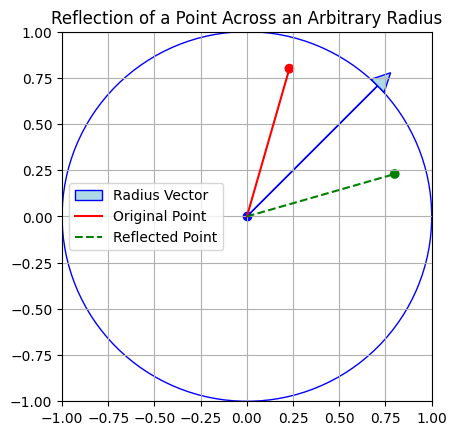

In [240]:
##Behaviour of particle reflected across radius

# Simulations

The code below simulates the brownian motion, the initial position is randomly initialized inside the allowed region and then the position and distance from the center is recorded and checks are performed to understand it the particle sits inside or outside the cell. 

In [12]:
def simulate_brownian_motion(opening_angle, radius, drift_velocity,diffusion_coefficient,time_step= 0.01, max_steps = 2000, mode = 'simulate'):
    # we make sure to initialize the point inside the region, this is more relevant for bigger theta values
    angle = np.random.uniform(0, 2 * np.pi)
    r = np.random.uniform(0, radius)
    x, y = r * np.cos(angle), r * np.sin(angle)
    while crosses_segment(x, y, 0,0, opening_angle,radius): 
        angle = np.random.uniform(0, 2 * np.pi)
        r = np.random.uniform(0, radius)
        x, y = r * np.cos(angle), r * np.sin(angle)
    
    path_x, path_y = [x], [y]
    time  = 0 
    for _ in range(max_steps):
        x_old, y_old = x, y

        x += drift_velocity[0]*time_step + np.sqrt(2 * diffusion_coefficient * time_step) * np.random.randn()
        y += drift_velocity[1]*time_step + np.sqrt(2 * diffusion_coefficient * time_step) * np.random.randn()
        
        r = np.sqrt(x**2 + y**2)
        
        if crosses_segment(x_old, y_old, x, y, opening_angle,radius):
            if mode != 'simulate': 
                path_x.append(x)
                path_y.append(y)
                return path_x, path_y
            return time
            

        if r >= radius:
            theta = np.arctan2(y, x)
            if theta < 0:
                theta += 2 * np.pi  # Ensure theta is in [0, 2pi]
            if is_in_opening(theta, opening_angle):
                if mode != 'simulate':
                    path_x.append(x)
                    path_y.append(y)
                    return path_x, path_y
                return time 
            else:
                x, y = rotate_particle(x_old, y_old, x, y, radius)

        if mode !='simulate': 
            path_x.append(x)
            path_y.append(y)
        time += 1
    if mode == 'simulate': 
        return time 
    else: 
        return path_x, path_y

We first simulate one run of the particle, below you can see how the particle is considered to be outside as soon as it crosses the cord defining the circular segment, this case we took $\theta$ = 45 degrees

In [356]:
radius = 1
path_x, path_y = simulate_brownian_motion(np.pi/2,1, drift_velocity=np.array([0.0, 0.0]), diffusion_coefficient=1, mode = 'plot')
opening_angle = np.pi/2

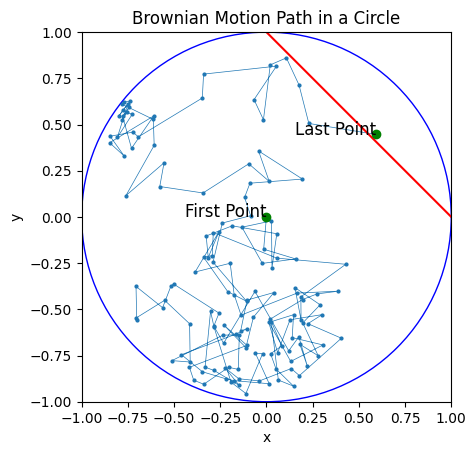

In [357]:
fig, ax = plt.subplots()
ax.plot(path_x, path_y, marker='o', markersize=2, linestyle='-', linewidth=0.5)

# Plot the circle boundary
circle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(circle)
ax.plot([radius, radius * np.cos(opening_angle)], [0, radius * np.sin(opening_angle)], 'r')
ax.plot(path_x[0], path_y[0], 'go')  # Mark the last point
ax.text(path_x[0], path_y[0], 'First Point', fontsize=12, ha='right')   
ax.plot(path_x[-1], path_y[-1], 'go')  # Mark the last point
ax.text(path_x[-1], path_y[-1], 'Last Point', fontsize=12, ha='right')
plt.xlim(-radius, radius)
plt.ylim(-radius, radius)
ax.set_aspect('equal', 'box')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Brownian Motion Path in a Circle')
plt.show()


## Different Opening Angles

Next simulate the behaviour with different angles, these start from 30 degrees to 180 degrees each time incremented by 15 degrees. Without loss of generality we assume that the zero value for the angle $\theta$ lies on the x-axis.  

In [15]:
SIMULATIONS = 2000
max_steps = 2000
angles = np.arange(np.pi/6, np.pi, np.pi/12)


exit_times = dict()
for angle in angles: 
    times = []
    
    for i in range(SIMULATIONS): 
        time = simulate_brownian_motion(angle, 1, np.array([0,0]),1)

        times.append(time)
    exit_times[angle] = times

## Mean First Passage Times with $\mu(x,y)$ = 0 


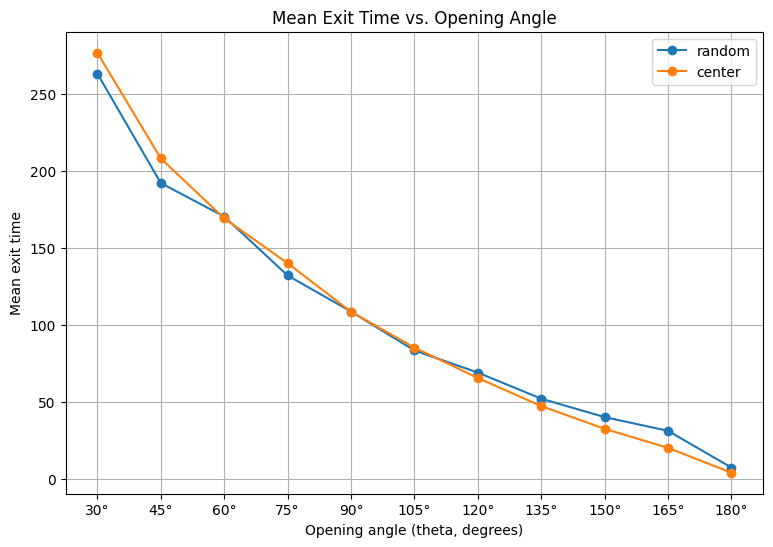

In [328]:
plt.figure(figsize = (9,6))
plt.plot(angles, mean_exit_times, 'o-', label = 'random')
plt.plot(angles, mean_exit_times1, 'o-', label = 'center')
plt.legend()
plt.xlabel('Opening angle (theta, degrees)')
plt.ylabel('Mean exit time')
plt.title('Mean Exit Time vs. Opening Angle')
plt.grid(True) # Example: from 0 to 360 degrees with 45-degree intervals
degree_labels = [f"{np.degrees(angle):.0f}°" for angle in angles]
plt.xticks(angles, degree_labels)
plt.show()

We notice how initializing the point at the center leads to slightly higher mean first passage time for angles that are small, then the behaviour is similar for angles in the middle range and finally center initialization performs better as the angle increases. This is reasonable as in regimes with smaller angles random initialization allows for the particle to be initialized closer to the opening, whereas for bigger angles starting from the center makes the particle already closer to the cord, as opposed to randomly initializing its position inside the allowed region. 
Generally speaking we observe the expected behaviour for which larger opening angles lead to smaller first passage times. 

The different exit times corresponding to the same angle posess a very high standard deviation as shown in the plot below 

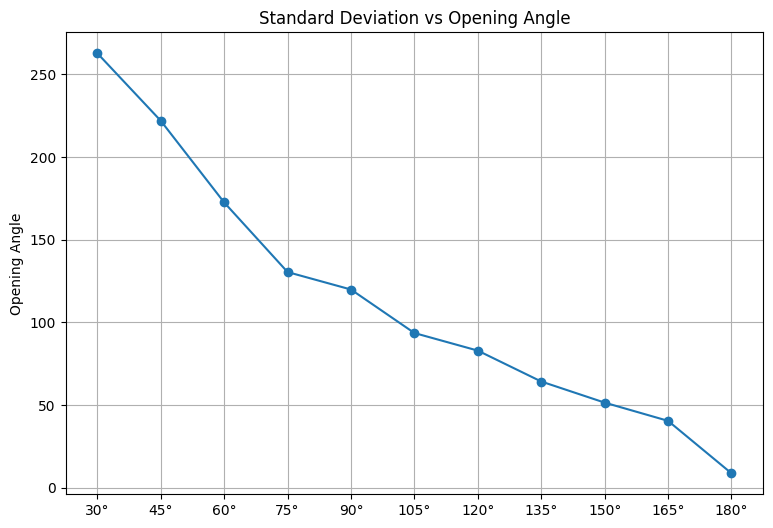

In [42]:
std = [np.std(exit_times[key]) for key in exit_times.keys()]
plt.figure(figsize = (9,6))
plt.plot(list(exit_times.keys()), std, '-o')
degree_labels = [f"{np.degrees(angle):.0f}°" for angle in angles]
plt.xticks(angles, degree_labels)
plt.grid(True)
plt.ylabel('Opening Angle')
plt.title('Standard Deviation vs Opening Angle')
plt.show()

## Density Functions 

c:\Users\yucha\machine_learning_new\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\yucha\machine_learning_new\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\yucha\machine_learning_new\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\yucha\machine_learning_new\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



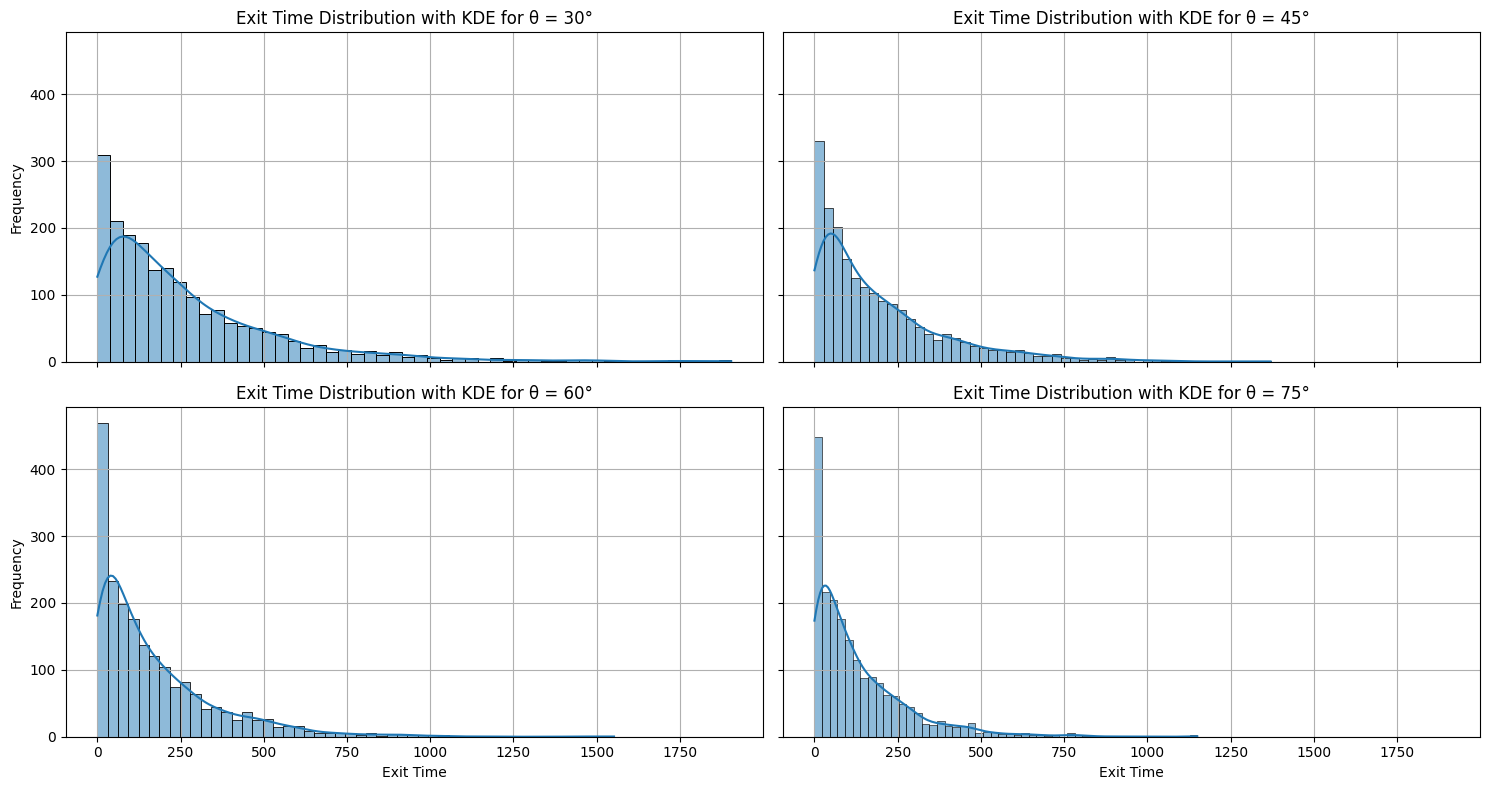

In [327]:
n_plots = 4
i = 0
fig, axes = plt.subplots(2,2,figsize=(15, 8), sharex = True, sharey = True )# Adjust the figure size and number of rows based on your data
axes = axes.flatten()
for ax, (angle, times) in zip(axes, exit_times.items()):
    i+=1

    sns.histplot(times, bins=50, kde=True, ax=ax);
    ax.set_xlabel('Exit Time')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Exit Time Distribution with KDE for θ = {np.degrees(angle):.0f}°')
    ax.grid(True)
    if i>4: 
        break

plt.tight_layout()
plt.show()

As expected we observe that for smaller angles the distribution has heavier tail and the peak of the distribution is shifted towards smaller values as the angle increases. 

Below is the cdf of the mean passage time that exhibit the same behaviour



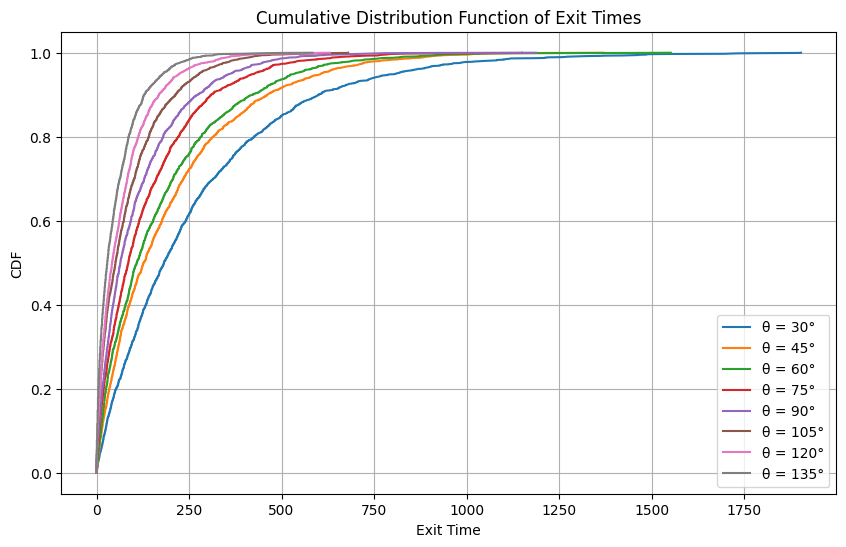

In [333]:
plt.figure(figsize=(10, 6))

# Process only the first 4 entries of the dictionary
for i, (key, times) in enumerate(exit_times.items()):
    if i >=8: 
        break
    sorted_times = np.sort(times)
    cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    plt.plot(sorted_times, cdf, label=f'θ = {np.degrees(key):.0f}°')  # Label in degrees for better readability

plt.xlabel('Exit Time')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Exit Times')
plt.grid(True)
plt.legend()
plt.show()


## Mean First Passage time with constant drift 

We now simulate the first passage time under the hypothesis that Brownian motion posesses a non-zero drift term. 

In [13]:
SIMULATIONS = 2000
max_steps = 2000
angles = np.arange(np.pi/6, np.pi, np.pi/12)


exit_times_drift = dict()
for angle in angles: 
    times = []
    
    for i in range(SIMULATIONS): 
        time = simulate_brownian_motion(angle, 1, np.array([0.5,0.5]),1)

        times.append(time)
    exit_times_drift[angle] = times

In [16]:
angles = list(exit_times_drift.keys())
mean_exit_times_drift = [np.mean(times) for times in exit_times_drift.values()]
mean_exit_times = [np.mean(times) for times in exit_times.values()]

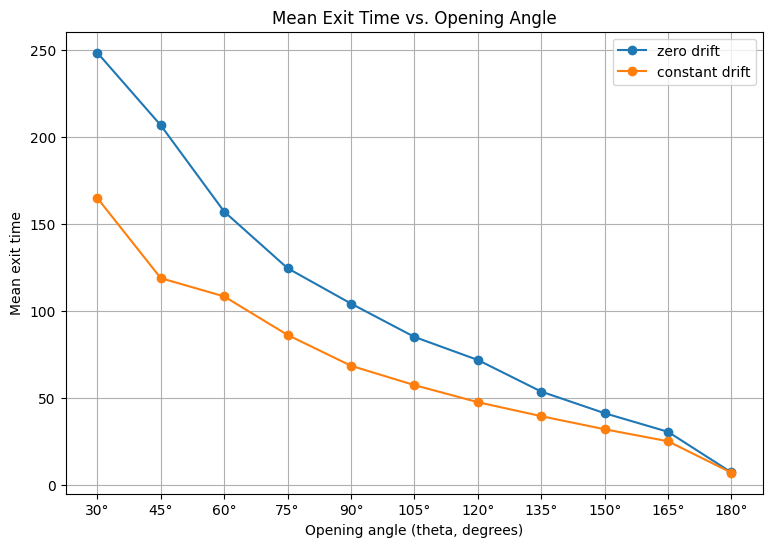

In [21]:
plt.figure(figsize = (9,6))
plt.plot(angles, mean_exit_times, '-o', label = 'zero drift')
plt.plot(angles, mean_exit_times_drift,'-o', label = 'constant drift')
plt.legend()
plt.xlabel('Opening angle (theta, degrees)')
plt.ylabel('Mean exit time')
plt.title('Mean Exit Time vs. Opening Angle')
plt.grid(True) # Example: from 0 to 360 degrees with 45-degree intervals
degree_labels = [f"{np.degrees(angle):.0f}°" for angle in angles]
plt.xticks(angles, degree_labels)
plt.show()
plt.show()

Compared with no drift we notice how the drift term, being  approximately aligned with the direction of the opening, leads to smaller mean exit times.

c:\Users\yucha\machine_learning_new\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yucha\machine_learning_new\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yucha\machine_learning_new\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\yucha\machine_learning_new\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

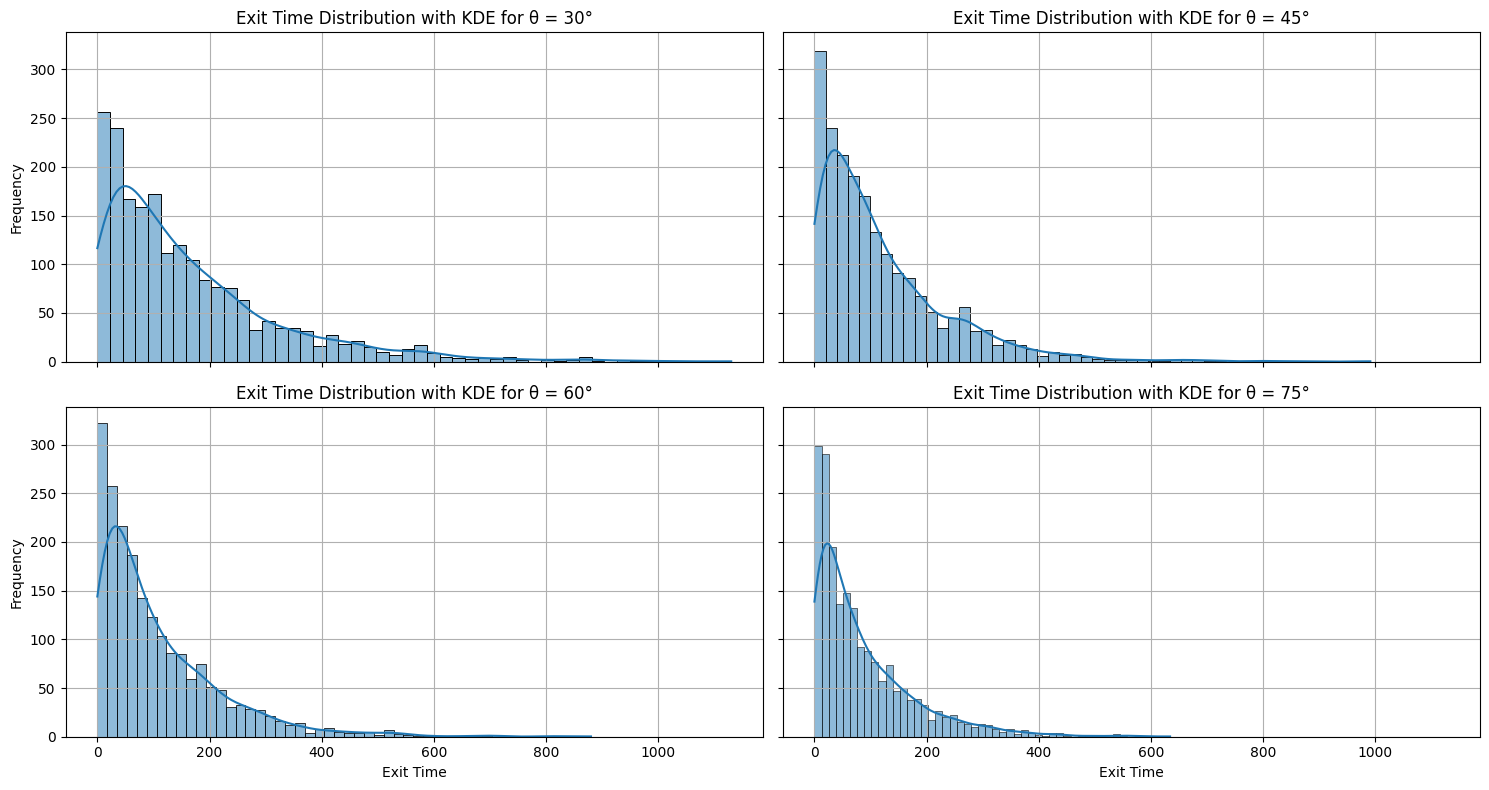

In [24]:
n_plots = 4
i = 0
fig, axes = plt.subplots(2,2,figsize=(15, 8), sharex = True, sharey = True )# Adjust the figure size and number of rows based on your data
axes = axes.flatten()
for ax, (angle, times) in zip(axes, exit_times_drift.items()):
    i+=1

    sns.histplot(times, bins=50, kde=True, ax=ax);
    ax.set_xlabel('Exit Time')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Exit Time Distribution with KDE for θ = {np.degrees(angle):.0f}°')
    ax.grid(True)
    if i>4: 
        break

plt.tight_layout()
plt.show()


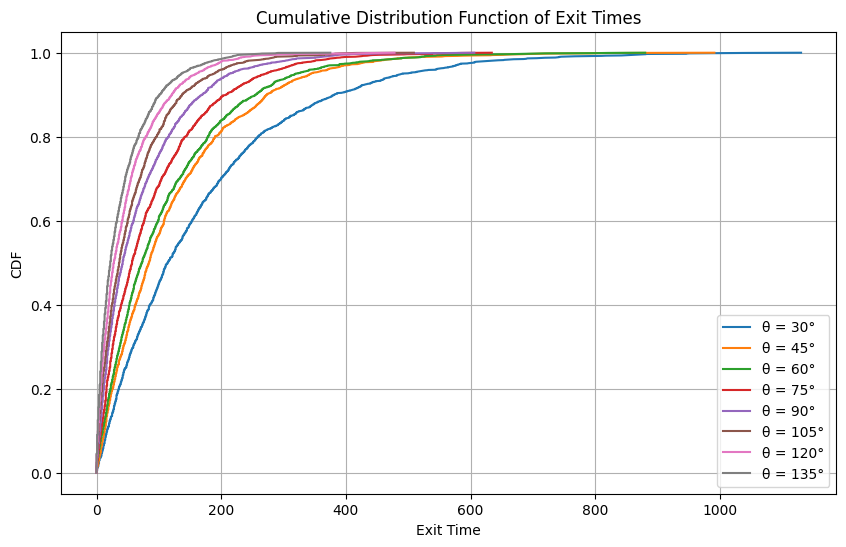

In [26]:
plt.figure(figsize=(10, 6))

# Process only the first 4 entries of the dictionary
for i, (key, times) in enumerate(exit_times_drift.items()):
    if i >=8: 
        break
    sorted_times = np.sort(times)
    cdf = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    plt.plot(sorted_times, cdf, label=f'θ = {np.degrees(key):.0f}°')  # Label in degrees for better readability

plt.xlabel('Exit Time')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function of Exit Times')
plt.grid(True)
plt.legend()
plt.show()

## Combination of different drift and diffusion constants

In this section we compare the mean exit times depending not only on the angle but also with varying diffusion coefficients and drift term, we impose the same drift term for both directions of motion. 

In [340]:
exit_times = dict()
diffusion_coefficients= [0.25, 0.5, 1, 2 ]
# we fix drift velocity and change diffusion coefficient 
for coeff in diffusion_coefficients:
    for angle in angles:
        times = []
        non_exit_prop = 0
        for i in range(SIMULATIONS):
            time = simulate_brownian_motion(angle, 1, drift_velocity=np.array([0,0]), diffusion_coefficient=coeff)


            times.append(time)
        exit_times[(coeff, angle)] = times


In [341]:
R, A = np.meshgrid(diffusion_coefficients, angles)
mean_exit_times = np.zeros_like(R, dtype=float)

for i, coeff in enumerate(diffusion_coefficients):
    for j, angle in enumerate(angles):
        if len(exit_times[(coeff, angle)]) > 0:
            mean_exit_times[j, i] = np.mean(exit_times[(coeff, angle)])
        else:
            mean_exit_times[j, i] = np.nan  # Handle cases where no exit occurred

# Convert angles to degrees for better readability
A_degrees = np.degrees(A)

# Create an interactive 3D plot using Plotly
fig = go.Figure(data=[go.Surface(z=mean_exit_times, x=R, y=A_degrees, colorscale='Viridis')])

# Update layout for better readability
fig.update_layout(
    title='Mean Exit Time vs. Diffusion Coefficient and Opening Angle',
    scene=dict(
        xaxis_title='Diffusion Coefficient',
        yaxis_title='Opening Angle (degrees)',
        zaxis_title='Mean Exit Time',
        aspectratio=dict(x=1, y=1, z=0.5)
    ),
    width=1000,
    height=800
)

# Show the interactive plot
fig.show()

In [343]:
exit_times = dict()
# we fix diffusion coefficient and change drift velocity
drift_velocity= [np.array([0,0]), np.array([0.1,0.1]),np.array([0.5,0.5]),np.array([1,1])]
for drift in drift_velocity:
    for angle in angles:
        times = []
        non_exit_prop = 0
        for i in range(SIMULATIONS):
            time = simulate_brownian_motion(angle, 1, drift_velocity=drift,diffusion_coefficient=1)


            times.append(time)
        exit_times[(drift[0], angle)] = times

In [346]:
R, A = np.meshgrid([0,0.1,0.5,1], angles)
mean_exit_times = np.zeros_like(R, dtype=float)

for i, drift in enumerate(drift_velocity):
    for j, angle in enumerate(angles):
        if len(exit_times[(drift[0], angle)]) > 0:
            mean_exit_times[j, i] = np.mean(exit_times[(drift[0], angle)])
        else:
            mean_exit_times[j, i] = np.nan  # Handle cases where no exit occurred

# Convert angles to degrees for better readability
A_degrees = np.degrees(A)

# Create an interactive 3D plot using Plotly
fig = go.Figure(data=[go.Surface(z=mean_exit_times, x=R, y=A_degrees, colorscale='Viridis')])

# Update layout for better readability
fig.update_layout(
    title='Mean Exit Time vs. Drift coefficient and Opening Angle',
    scene=dict(
        xaxis_title='Drift Coefficient',
        yaxis_title='Opening Angle (degrees)',
        zaxis_title='Mean Exit Time',
        aspectratio=dict(x=1, y=1, z=0.5)
    ),
    width=1000,
    height=800
)

# Show the interactive plot
fig.show()

We observe how increasing drift and diffusion coefficient leads to lower mean first passage time. In particular increasing diffusion coeffiecient leads to a steeper decrease of the mean passage time when these coefficients are low. 

# Conclusion

We investigated the mean exit time of a particle diffusing in a 2D circular domain and escaping through a section defined by an angle $\theta$. Since an analytical description of the problem can be challenging we simulated the behaviour of the particle and carefully define boundary behaviour and simulate passage time with varying angles. 

We observe that for fixed diffusion coefficients and drift term the mean first passage time decreases as the opening angle $\theta$ increases, for low angle value the exit times are extremely variable due to the stochastic nature of the brownian motion, we then analyze the density and cumulative distribution of these quantities.

Finally we compared mean first passage time as a function of both angle and drift/diffusion coefficient. Concluding that a drift term that is positive and different than 0 lowers the mean first passage time when compared to a 2D Brownian motion with no drift, and that increasing values of these coefficient lead to smaller mean first passage time.